In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import time
import variance_curve
import ImpliedDrift as iD
import Heston
import rHeston
import Quintic
import BlackScholes as bs
import arviz as az
import pymc as pm
import pytensor.tensor as pt
import time

from rbergomi import rBergomi
from matplotlib import cm

In [76]:
# Read the dataset
spot = np.array(pd.read_csv("spot.csv").Spot).flatten()
index = 0; S0 = spot[index];

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.
m = len(K); n =len(maturities);
K = S0 * moneyness / 100

# Read the iv of the models

aux = np.array(pd.read_csv("Heston.csv")).reshape((m,n))
aux1 = np.array(pd.read_csv("rHeston.csv")).reshape((m,n))
aux2 = np.array(pd.read_csv("rBergomi.csv")).reshape((m,n))
aux3 = np.array(pd.read_csv("QuintOU.csv")).reshape((m,n))

IV_models = np.array([aux,aux1,aux2,aux3])

IV = IV.flatten()

def f(rng, w1, w2, w3, w4, size = None):    
    return (w1*IV_models[0,:,:]+w2*IV_models[1,:,:]+\
            w3*IV_models[2,:,:]+w4*IV_models[3,:,:]).flatten()

In [77]:
start_time = time.time()

with pm.Model() as model_lv:
    w1 = pm.Uniform("w1", lower = 0, upper = 1)
    w2 = pm.Uniform("w2", lower = 0, upper = 1 - w1)
    w3 = pm.Uniform("w3", lower = 0, upper = 1 - w1 - w2)
    w4 = pm.Deterministic("w4", 1. - w1 - w2 - w3)
    
    sim = pm.Simulator("sim", f, params = (w1,w2,w3,w4), epsilon = 0.01, 
                       observed = IV, distance = 'gaussian', sum_stat = 'sort')

    idata_lv = pm.sample_smc(draws = 10000, chains = 4, progressbar=False)
    
print(f'Elapsed time: {time.time()-start_time: .2f}s')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Elapsed time:  37.48s


<IPython.core.display.Javascript object>


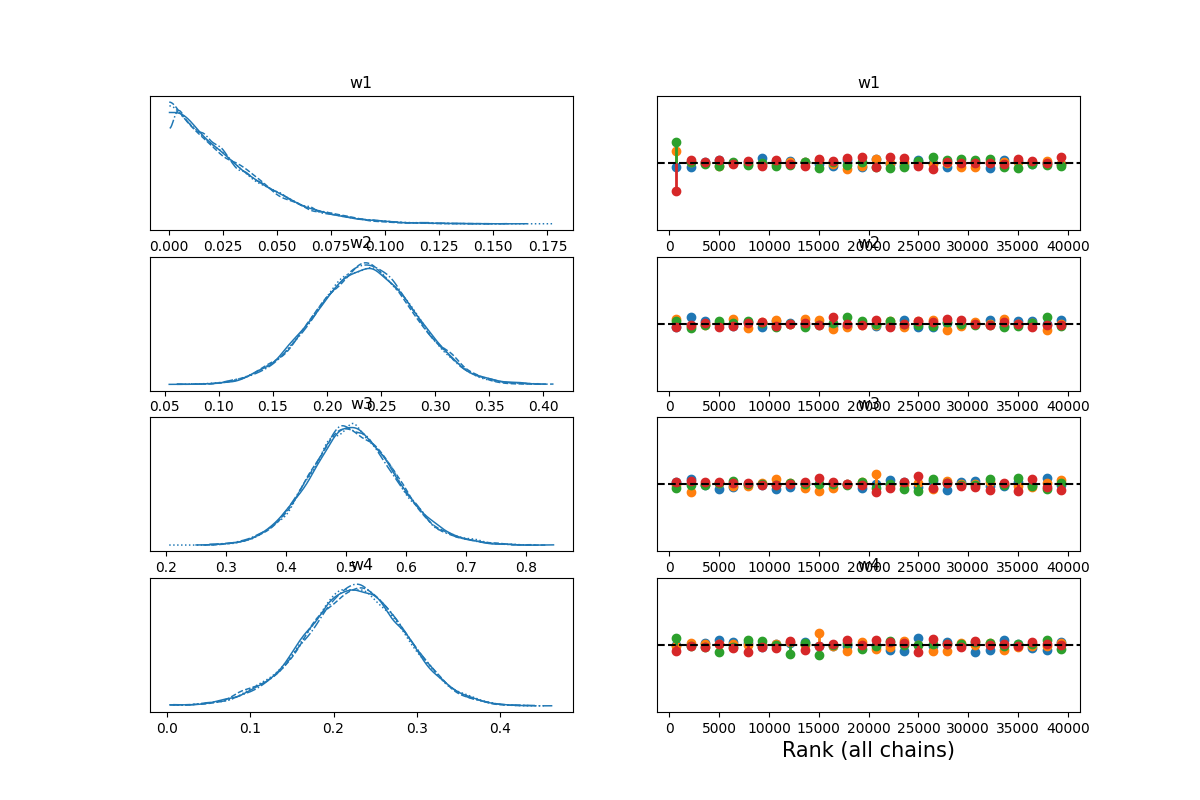

In [78]:
az.plot_trace(idata_lv, kind="rank_vlines");

<IPython.core.display.Javascript object>


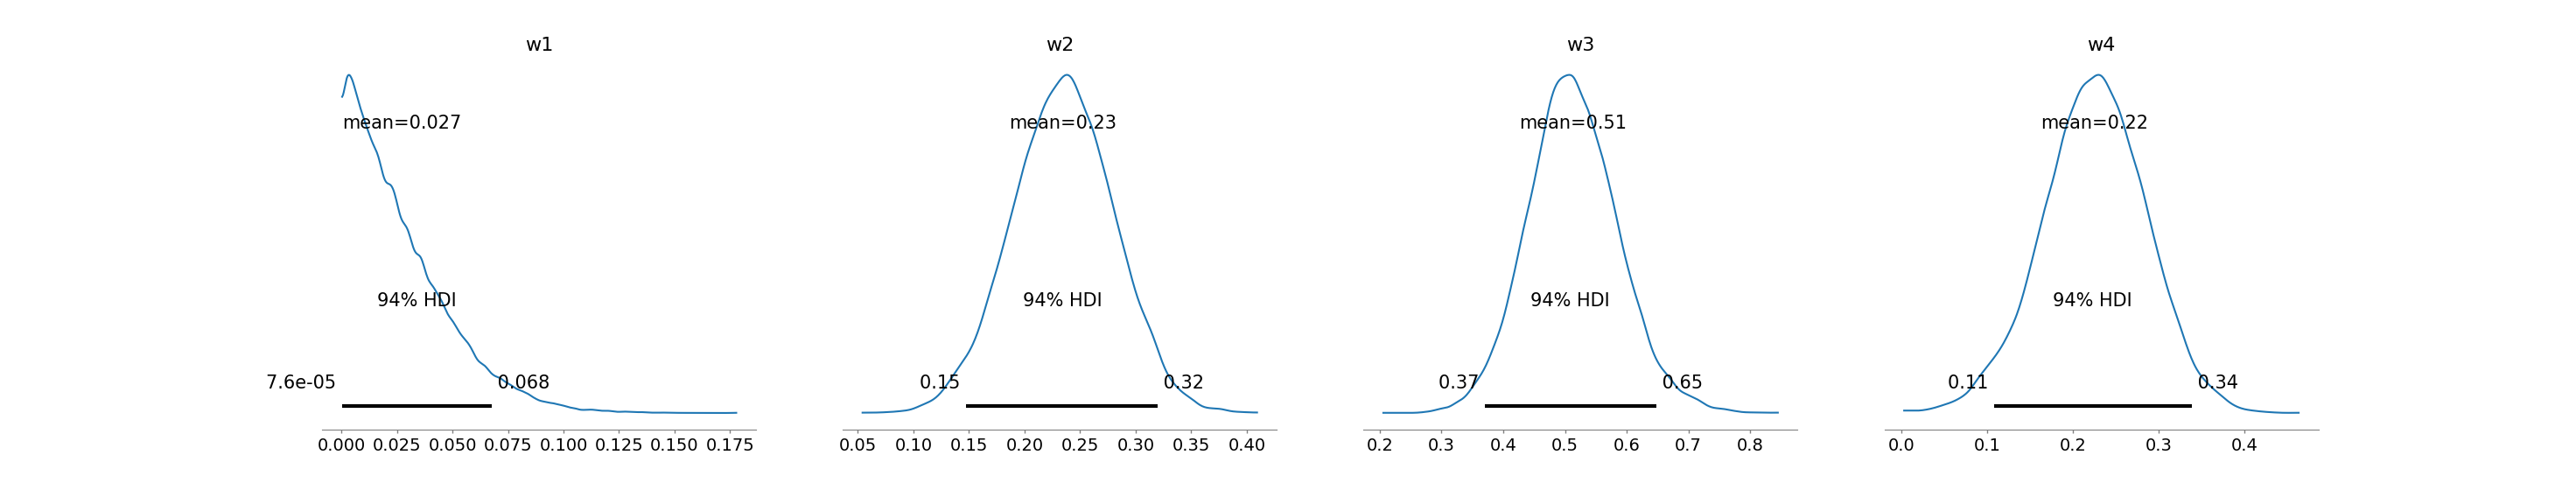

In [80]:
az.plot_posterior(idata_lv);